## imports e declarações

In [1]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
col = ["Abandono","Cancelamento","Classificado e Não Matriculado","Desligamento","Transferido"]

# Preparação, limpeza e agregação

## preparação e limpeza do dataset 1

In [2]:
def cleardb1(data):
    data.columns = data.loc[0]
    data.drop(data.index[:1], inplace=True)
    data.drop(data.index[-1], inplace=True)
    data["Campus"].fillna(method='ffill', inplace=True)
    data.rename({"NOME_CURSO": "curso", "Campus": "campus"}, axis=1, inplace=True)
    data.curso = data.curso.str.title()
    data["modalidade"]='Não especificado'
    data["turno"]='Não especificado'
    
    for i in col:
        if i not in data.columns:
            data[i] = np.nan
    for i in col:
        data[i].fillna(0, inplace=True)
    data.dropna(axis=1, inplace=True)
    data['curso']=data['curso'].str[9:]
    data.reset_index(drop=True, inplace=True)


#carregando as databases e limpando com os metodos definidos anteriormente
d061 = pd.read_csv("./data/evasao - 061.csv", encoding = "utf-8")
cleardb1(d061)
d061.drop(columns=["Nº de alunos"], inplace=True)

d062 = pd.read_csv("./data/evasao - 062.csv", encoding = "utf-8")
cleardb1(d062)
d062.drop(columns=["Nº de alunos"], inplace=True)

d071 = pd.read_csv("./data/evasao - 071.csv", encoding = "utf-8")
cleardb1(d071)
d071.drop(columns=["Nº alunos"], inplace=True)

d072 = pd.read_csv("./data/evasao - 072.csv", encoding = "utf-8")
cleardb1(d072)
d072.drop(columns=["Nº de alunos"], inplace=True)

## preparação e limpeza do dataset 2

In [3]:
def cleardb2(data, lastline):
    data.columns = data.loc[1]
    data.drop(data.index[:2], inplace=True)
    data.drop(data.index[lastline], inplace=True)
    data["NOME_CURSO"].fillna(method='ffill', inplace=True)
    try:
        data["Campus"].fillna(method='ffill', inplace=True)
    except:
        pass
    data.dropna(1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = split(data)
    data = pivoting(data)
    data.curso = data.curso.str.title()
    data['curso']=data['curso'].str[9:]
    return data
    
def split(data):
    
    ocorrencia = data[["Ocorrência/forma de evasão"]]
    ocorrencia = pd.DataFrame(ocorrencia["Ocorrência/forma de evasão"].str.split("=").tolist())
    data = pd.concat([data, ocorrencia], axis=1, join_axes=[d081.index])
    
    data.drop(columns=["Ocorrência/forma de evasão"], inplace=True)
    data.rename({"NOME_CURSO": "curso", 0:"tipo", 1:"quantidade"}, axis=1, inplace=True)
    data.quantidade = data.quantidade.apply(pd.to_numeric)
    return data

def pivoting(data):
    data.dropna(inplace=True)
    data1 = data.pivot(index="curso", columns='tipo', values="quantidade")
    data1.fillna(0, inplace=True)
    data1.reset_index(inplace=True)
    if("Campus" in data):
        data.rename({"Campus":"campus"}, axis=1, inplace=True)
        data1 = pd.concat([data1, data.campus], axis=1)
    else:
        data["campus"] = pd.Series(['' for i in range(len(data['curso']))])
        data1 = pd.concat([data1, data.campus], axis=1)
    data1.dropna(axis=0, inplace=True)
    return data1

In [4]:
#carregando as databases e limpando com os metodos definidos anteriormente
d081 = pd.read_csv("./data/evasao - 081.csv", encoding = "utf-8")
d081 = cleardb2(d081,-4)

d082 = pd.read_csv("./data/evasao - 082.csv", encoding = "utf-8")
d082 = cleardb2(d082, -5)

d091 = pd.read_csv("./data/evasao - 091.csv", encoding = "utf-8")
d091 = cleardb2(d091, -8)

d092 = pd.read_csv("./data/evasao - 092.csv", encoding = "utf-8")
d092 = cleardb2(d092, -6)

d101 = pd.read_csv("./data/evasao - 101.csv", encoding = "utf-8")
d101 = cleardb2(d101, -8)

d102 = pd.read_csv("./data/evasao - 102.csv", encoding = "utf-8")
d102 = cleardb2(d102,-7)

d111 = pd.read_csv("./data/evasao - 111.csv", encoding = "utf-8")
d111 = cleardb2(d111,-5)
d111

,curso,Abandono,Cancelamento,Classificado e Não Matriculado,Sem Matrícula,Transferência,campus
0,Agronomia,0.0,1.0,0.0,0.0,0.0,Alegrete
1,Ciencia Da Computacao,0.0,6.0,0.0,0.0,0.0,Alegrete
2,Engenharia Agrícola,2.0,1.0,0.0,0.0,0.0,Alegrete
3,Engenharia Civil,0.0,3.0,0.0,0.0,2.0,Alegrete
4,Engenharia De Computacao,1.0,1.0,0.0,0.0,0.0,Alegrete
5,Engenharia De Producao,0.0,0.0,1.0,0.0,0.0,Alegrete
6,Engenharia De Software,0.0,2.0,0.0,0.0,1.0,Alegrete
7,Engenharia Eletrica,0.0,8.0,0.0,0.0,0.0,Alegrete
8,Engenharia Mecanica,0.0,5.0,0.0,0.0,0.0,Bagé
9,Engenharia Quimica,0.0,1.0,0.0,0.0,1.0,Bagé


In [5]:
#com base com todas as planilhas anteriores pega todos os cursos e seus campus
datasets = [d061[["curso", "campus"]],d062[["curso", "campus"]],d071[["curso", "campus"]],d072[["curso", "campus"]],
            d081[["curso", "campus"]],d082[["curso", "campus"]],d091[["curso", "campus"]],d092[["curso", "campus"]],
            d101[["curso", "campus"]],d102[["curso", "campus"]],d111[["curso", "campus"]]]

cursos = pd.concat(datasets)
cursos = cursos[cursos.campus != '']
cursos.drop_duplicates(inplace=True)
cursos.sort_values(by="campus", inplace=True)
cursos.reset_index(drop=True, inplace=True)

## limpesa e preparação do dataset 3

In [6]:
a2015m11 = pd.read_csv("data/nAlunosPorMes/a2015m11.csv", encoding = "ISO-8859-1")
a2015m12d22 = pd.read_csv("data/nAlunosPorMes/a2015m12d22.csv", encoding = "ISO-8859-1")
a2015m12d29 = pd.read_csv("data/nAlunosPorMes/a2015m12d29.csv", encoding = "ISO-8859-1")

a2016m01 = pd.read_csv("data/nAlunosPorMes/a2016m01.csv", encoding = "ISO-8859-1")
a2016m02 = pd.read_csv("data/nAlunosPorMes/a2016m02.csv", encoding = "ISO-8859-1")
a2016m03 = pd.read_csv("data/nAlunosPorMes/a2016m03.csv", encoding = "ISO-8859-1")
a2016m04 = pd.read_csv("data/nAlunosPorMes/a2016m04.csv", encoding = "ISO-8859-1")
a2016m05 = pd.read_csv("data/nAlunosPorMes/a2016m05.csv", encoding = "ISO-8859-1")
a2016m06 = pd.read_csv("data/nAlunosPorMes/a2016m06.csv", encoding = "ISO-8859-1")
a2016m07 = pd.read_csv("data/nAlunosPorMes/a2016m07.csv", encoding = "ISO-8859-1")
a2016m08 = pd.read_csv("data/nAlunosPorMes/a2016m08.csv", encoding = "ISO-8859-1")
a2016m10 = pd.read_csv("data/nAlunosPorMes/a2016m10.csv", encoding = "ISO-8859-1")
a2016m11 = pd.read_csv("data/nAlunosPorMes/a2016m11.csv", delimiter=';', encoding = "ISO-8859-1")
a2016m12 = pd.read_csv("data/nAlunosPorMes/a2016m12.csv", delimiter=';', encoding = "ISO-8859-1")

a2017m01 = pd.read_csv("data/nAlunosPorMes/a2017m01.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m02 = pd.read_csv("data/nAlunosPorMes/a2017m02.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m03 = pd.read_csv("data/nAlunosPorMes/a2017m03.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m04 = pd.read_csv("data/nAlunosPorMes/a2017m04.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m05 = pd.read_csv("data/nAlunosPorMes/a2017m05.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m07 = pd.read_csv("data/nAlunosPorMes/a2017m07.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m08 = pd.read_csv("data/nAlunosPorMes/a2017m08.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m09 = pd.read_csv("data/nAlunosPorMes/a2017m09.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m11 = pd.read_csv("data/nAlunosPorMes/a2017m11.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m12 = pd.read_csv("data/nAlunosPorMes/a2017m12.csv", delimiter=',', encoding = "ISO-8859-1")

a2018m01 = pd.read_csv("data/nAlunosPorMes/a2018m01.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m02 = pd.read_csv("data/nAlunosPorMes/a2018m02.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m03 = pd.read_csv("data/nAlunosPorMes/a2018m03.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m04 = pd.read_csv("data/nAlunosPorMes/a2018m04.csv", delimiter=',', encoding = "ISO-8859-1")

#colocando as referencias da lista para fazer uma primeira limpeza
thiasSets=[a2015m11, a2015m12d22, a2015m12d29,
          a2016m01,a2016m02, a2016m03, a2016m04, a2016m05, a2016m06, a2016m07, a2016m08, a2016m10, a2016m11, a2016m12,
          a2017m01, a2017m02, a2017m03,a2017m04, a2017m05, a2017m07, a2017m08, a2017m09, a2017m11, a2017m12,
          a2018m01,a2018m02,a2018m03,a2018m04]

#constantes para jogar as tabelas em dataframes
a=['nome do curso','campus', 'nível', 'turno', 'modalidade',  'alunos matriculados']
b=['nome do curso', 'campus', 'nível', 'turno', 'modalidade']

print ("done")


done


In [7]:
find=['Letras -  Com Habilitação Em Lingua Portuguesa E Respectivas Literaturas', 
      'Letras -  Com Habilitação Em Língua Portuguesa E Respectivas Literaturas',
     'Geografia Licenciatura', 'Licenciatura Em Educação Física', 'Licenciatura Em Pedagogia', 
     'Engenharia Em Agrimensura']
repl=['Letras Português']*2+['Licenciatura Em Geografia','Educação Física', 'Pedagogia', 'Engenharia De Agrimensura']

for i in range (len(thiasSets)):
    thiasSets[i]['nome do curso']=thiasSets[i]['nome do curso'].str.title()
    thiasSets[i]['nome do curso']=thiasSets[i]['nome do curso'].str.strip()
    for j in range (len(find)):
        thiasSets[i]['nome do curso']=thiasSets[i]['nome do curso'].str.replace(find[j],repl[j])

In [8]:
#Datasets 2016-01 a 2016-12
df1602=pd.merge(a2016m01[a],a2016m02[a], how='outer', on=b, suffixes=(' em 16-01',' em 16-02'))
df1603=pd.merge(df1602,a2016m03[a], how='outer', on=b)
df1604=pd.merge(df1603,a2016m04[a], how='outer', on=b, suffixes=(' em 16-03',' em 16-04'))
df1605=pd.merge(df1604,a2016m05[a], how='outer', on=b)
df1606=pd.merge(df1605,a2016m06[a], how='outer', on=b, suffixes=(' em 16-05',' em 16-06'))
df1607=pd.merge(df1606,a2016m07[a], how='outer', on=b)
df1608=pd.merge(df1607,a2016m08[a], how='outer', on=b, suffixes=(' em 16-07',' em 16-08'))
df1610=pd.merge(df1608,a2016m10[a], how='outer', on=b)
df1611=pd.merge(df1610,a2016m11[a], how='outer', on=b, suffixes=(' em 16-10',' em 16-11'))
df16final=pd.merge(df1611,a2016m11[a], how='outer', on=b)

df16final.drop(df16final.loc[df16final.nível!='Graduação'].index, inplace=True)
df16final.rename({'alunos matriculados': 'alunos matriculados em 16-12'}, axis=1, inplace=True)
df16final.sort_values(by=['campus', 'nome do curso'], inplace=True, ascending=True)
df16final.reset_index(drop=True, inplace=True)

df16final



,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 16-01,alunos matriculados em 16-02,alunos matriculados em 16-03,alunos matriculados em 16-04,alunos matriculados em 16-05,alunos matriculados em 16-06,alunos matriculados em 16-07,alunos matriculados em 16-08,alunos matriculados em 16-10,alunos matriculados em 16-11,alunos matriculados em 16-12
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,151.0,149.0,190.0,172.0,172.0,172.0,170.0,168.0,145.0,145.0,145.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,180.0,180.0,196.0,201.0,200.0,199.0,198.0,196.0,178.0,178.0,178.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,283.0,278.0,312.0,305.0,305.0,305.0,305.0,303.0,272.0,272.0,272.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,147.0,146.0,181.0,170.0,170.0,170.0,170.0,170.0,141.0,141.0,141.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,96.0,92.0,137.0,121.0,120.0,119.0,118.0,117.0,110.0,110.0,110.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,209.0,205.0,242.0,240.0,241.0,241.0,240.0,234.0,226.0,226.0,226.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,227.0,227.0,267.0,251.0,251.0,251.0,248.0,247.0,224.0,224.0,224.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,109.0,108.0,149.0,134.0,133.0,133.0,132.0,133.0,112.0,112.0,112.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,195.0,193.0,242.0,221.0,223.0,223.0,222.0,226.0,196.0,196.0,196.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,NaN,NaN,138.0,149.0,150.0,151.0,153.0,158.0,146.0,147.0,147.0


In [9]:
#Datasets 2017-01 a 2017-12

df1702=pd.merge(a2017m01[a],a2017m02[a], how='outer', on=b, suffixes=(' em 17-01',' em 17-02'))
df1703=pd.merge(df1702,a2017m03[a], how='outer', on=b)
df1704=pd.merge(df1703,a2017m04[a], how='outer', on=b, suffixes=(' em 17-03',' em 17-04'))
df1705=pd.merge(df1704,a2017m05[a], how='outer', on=b)
df1707=pd.merge(df1705,a2017m07[a], how='outer', on=b, suffixes=(' em 17-05',' em 17-07'))
df1708=pd.merge(df1707,a2017m08[a], how='outer', on=b)
df1709=pd.merge(df1708,a2017m09[a], how='outer', on=b, suffixes=(' em 17-08',' em 17-09'))
df1711=pd.merge(df1709,a2017m11[a], how='outer', on=b)
df17final=pd.merge(df1711,a2017m12[a], how='outer', on=b, suffixes=(' em 17-11',' em 17-12'))

df17final.drop(df17final.loc[df17final.nível!='Graduação'].index, inplace=True)
df17final.reset_index(drop=True, inplace=True)
df17final.sort_values(by=['campus', 'nome do curso'], inplace=True)

df17final

#df17final[df17final['nome do curso'].str.contains('Educa')]
#[print (d) for d in df17final[71:]['nome do curso']]
#t=df17final[df17final['nome do curso'].str.contains('Letras')][['nome do curso','campus']]
#t['nome do curso'].str.strip().value_counts()
#[print (d) for d in df17final[df17final['nome do curso'].str.contains('Letras')]['nome do curso']]

,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 17-01,alunos matriculados em 17-02,alunos matriculados em 17-03,alunos matriculados em 17-04,alunos matriculados em 17-05,alunos matriculados em 17-07,alunos matriculados em 17-08,alunos matriculados em 17-09,alunos matriculados em 17-11,alunos matriculados em 17-12
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,145.0,137.0,179.0,182.0,166.0,164.0,161.0,160.0,148.0,148.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,178.0,174.0,193.0,228.0,204.0,204.0,204.0,208.0,185.0,185.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,272.0,262.0,307.0,309.0,292.0,291.0,289.0,267.0,260.0,260.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,141.0,134.0,180.0,182.0,166.0,166.0,164.0,161.0,147.0,146.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,109.0,105.0,134.0,138.0,123.0,121.0,119.0,121.0,116.0,116.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,226.0,216.0,256.0,259.0,244.0,244.0,242.0,236.0,223.0,223.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,224.0,217.0,256.0,252.0,234.0,236.0,232.0,222.0,211.0,211.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,112.0,114.0,150.0,151.0,143.0,142.0,144.0,139.0,127.0,127.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,196.0,189.0,236.0,235.0,217.0,217.0,217.0,209.0,187.0,187.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,147.0,149.0,193.0,196.0,195.0,182.0,186.0,184.0,168.0,168.0


In [10]:
#Datasets 2018-01 a 2018-04

df1802=pd.merge(a2018m01[a],a2018m02[a], how='outer', on=b, suffixes=(' em 18-01',' em 18-02'))
df1803=pd.merge(df1802,a2018m03[a], how='outer', on=b)
df18final=pd.merge(df1803,a2018m04[a], how='outer', on=b, suffixes=(' em 18-03',' em 18-04'))

df18final.drop(df18final.loc[df18final.nível!='Graduação'].index, inplace=True)
df18final.reset_index(drop=True, inplace=True)
df18final

,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 18-01,alunos matriculados em 18-02,alunos matriculados em 18-03,alunos matriculados em 18-04
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,148.0,143.0,188.0,173.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,185.0,180.0,197.0,212.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,259.0,228.0,277.0,259.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,146.0,138.0,186.0,168.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,116.0,112.0,148.0,141.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,223.0,208.0,238.0,239.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,211.0,199.0,245.0,228.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,127.0,122.0,150.0,139.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,187.0,188.0,236.0,204.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,167.0,163.0,189.0,178.0


In [11]:
df1617=pd.merge(df16final,df17final, how='outer', on=b)
df1618=pd.merge(df1617,df18final, how='outer', on=b)
#df1518=pd.merge(df15final,df1618, how='outer', on=b)
df1618



,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 16-01,alunos matriculados em 16-02,alunos matriculados em 16-03,alunos matriculados em 16-04,alunos matriculados em 16-05,...,alunos matriculados em 17-05,alunos matriculados em 17-07,alunos matriculados em 17-08,alunos matriculados em 17-09,alunos matriculados em 17-11,alunos matriculados em 17-12,alunos matriculados em 18-01,alunos matriculados em 18-02,alunos matriculados em 18-03,alunos matriculados em 18-04
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,151.0,149.0,190.0,172.0,172.0,...,166.0,164.0,161.0,160.0,148.0,148.0,148.0,143.0,188.0,173.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,180.0,180.0,196.0,201.0,200.0,...,204.0,204.0,204.0,208.0,185.0,185.0,185.0,180.0,197.0,212.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,283.0,278.0,312.0,305.0,305.0,...,292.0,291.0,289.0,267.0,260.0,260.0,259.0,228.0,277.0,259.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,147.0,146.0,181.0,170.0,170.0,...,166.0,166.0,164.0,161.0,147.0,146.0,146.0,138.0,186.0,168.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,96.0,92.0,137.0,121.0,120.0,...,123.0,121.0,119.0,121.0,116.0,116.0,116.0,112.0,148.0,141.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,209.0,205.0,242.0,240.0,241.0,...,244.0,244.0,242.0,236.0,223.0,223.0,223.0,208.0,238.0,239.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,227.0,227.0,267.0,251.0,251.0,...,234.0,236.0,232.0,222.0,211.0,211.0,211.0,199.0,245.0,228.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,109.0,108.0,149.0,134.0,133.0,...,143.0,142.0,144.0,139.0,127.0,127.0,127.0,122.0,150.0,139.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,195.0,193.0,242.0,221.0,223.0,...,217.0,217.0,217.0,209.0,187.0,187.0,187.0,188.0,236.0,204.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,NaN,NaN,138.0,149.0,150.0,...,195.0,182.0,186.0,184.0,168.0,168.0,167.0,163.0,189.0,178.0


In [12]:
#será considero que o primeiro semestre do ano comece em Abril (pois é quando são contabilizados os alunos matriculados 
#no mes de fevereiro e Março) e termine em Julho (mes onde são contabilidados os alunos matriculados no final do periodo letivo) e que o segundo semestre comece em Agosto(mês em que
# as ferias terminam e ocorrem as transferencias) e termine em Fevereiro (utlimo mes antes da contabilização das inscrições
#através do enem)
#O nível de precisão será menor do que das tabelas de antes de 2012, já que podem ter saído alunos nos meses em que novos 
# entram, assim, mascarando a quantidade de abandonos e de inscrições
#o calculo para ver a quantidade de desistencia de cada semestre será: 
#    quantidade de alunos no mês de inicio do semestre - quantidade de alunos no mês de termino do semestre.
# Então, para o primeiro semestre sera: Qntdd em Março - Qntdd em Julho
# E para o segundo semestre será: Qntdd em Agosto - Qntdd em Fevereiro
# Como os dados começam em Novembro de 2015 e terminam em Abril de 2018, o calculo do segundo semestre de 2015 será começado
# a partir de Novembro, e o fim do primeiro semestre de 2018 será em Abril, pois é até onde temos os dados

def dif(df1, mes1, mes2):
    retorno=df1.copy()
    #retorno = df1[(df1[col1]-df1[col2])<0][['nome do curso', 'campus', col1, col2]]
    pattern='alunos matriculados em '
    col1=pattern+mes1
    col2=pattern+mes2
    retorno['diff']=retorno[col1]-retorno[col2]
    return retorno[['nome do curso', 'campus','turno','modalidade', col1, col2, 'diff']]


#dif(df1518,'15-11','16-02')
#dif(df1518, '17-03', '17-07')
#df1518.fillna(0.0, inplace=True)
#df1518

#dif mensal ------------------------->>>>>>>>>>>>>>>>>>>
#df=df1518[['nome do curso', 'campus', 'turno','modalidade']]
#for i in range(6,len(df1518.columns)):
#        df['diff '+(df1518.columns[i-1][-5:]) +" a "+ (df1518.columns[i][-5:])]=(df1518[df1518.columns[i-1]] -df1518[df1518.columns[i]])
#df['abandonos']=0
#df['novos alunos']=0
#for i in range (len(df1518)):
#    abandonos=0;
#    novos_alunos=0
#    for j in range(5,len(df.columns)):
#        if(df[df.columns[j]][i]>0):
#            abandonos+=df[df.columns[j]][i]
#        else:
#            novos_alunos+=df[df.columns[j]][i]
#    df['novos alunos'][i]=novos_alunos*(-1)
#    df['abandonos'][i]=abandonos
#df     
#fim dif mensal --------------------->>>>>>>>>>>>>>>>>>
        
#df1518[(df1518['alunos matriculados em 15-11'] - df1518['alunos matriculados em 16-02'])<0][['nome do curso', 'campus','alunos matriculados em 15-11','alunos matriculados em 16-02']]
#dif(df1518,'16-03','16-07')

def addcols(df):
    df['classificado e não matriculado']=0
    df['cancelamento']=0
    df['desligamento']=0
    df['falecimento']=0
    df['transferência']=0
    return df
    
def diff(df, mes1, mes2):
    ab=dif(df, mes1, mes2)
    ab=ab[[c for c in ab.columns if 'alunos' not in c]]
    ab.rename({'diff': 'abandono'}, axis=1, inplace=True)
    ab.rename({'nome do curso': 'curso'}, axis=1, inplace=True)
    ab['abandono'].fillna(0, inplace=True)
    s=ab['abandono']
    s[s<0]=0
    ab['abandono']=s
    ab['campus'] = ab['campus'].str[7:]
    addcols(ab)
    ab.drop(df17final.loc[ab.curso=='Aluno Em Regime Especial De Graduacao'].index, inplace=True)
    df18final.reset_index(drop=True, inplace=True)
    ab['curso']=ab['curso'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    return ab

df1=diff(df1618,'16-04','16-07')
df2=diff(df1618,'16-08','17-02')
df3=diff(df1618,'17-04','17-07')
df4=diff(df1618,'17-08','18-02')
df5=diff(df1618,'18-03','18-04')

#b=['nome do curso', 'campus', 'turno', 'modalidade']
#dff=df1.merge(df2, how='outer', on=b, suffixes=(' de 16/01',' de 16/02')).merge(df3, how='outer', on=b).merge(df4, how='outer', on=b, suffixes=(' de 17/01',' de 17/02')).merge(df5, how='outer')
#dff.rename({'diff': 'diff de 18/01'}, axis=1, inplace=True)
#dff=dff[[c for c in dff.columns if 'alunos' not in c]]
#cleardb1(df1)

df1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,curso,campus,turno,modalidade,abandono,classificado e não matriculado,cancelamento,desligamento,falecimento,transferência
0,Ciencia Da Computacao,Alegrete,Noturno,Bacharelado,2.0,0,0,0,0,0
1,Engenharia Agricola,Alegrete,Integral,Bacharelado,3.0,0,0,0,0,0
2,Engenharia Civil,Alegrete,Integral,Bacharelado,0.0,0,0,0,0,0
3,Engenharia De Software,Alegrete,Noturno,Bacharelado,0.0,0,0,0,0,0
4,Engenharia De Telecomunicacoes,Alegrete,Integral,Bacharelado,3.0,0,0,0,0,0
5,Engenharia Eletrica,Alegrete,Integral,Bacharelado,0.0,0,0,0,0,0
6,Engenharia Mecanica,Alegrete,Integral,Bacharelado,3.0,0,0,0,0,0
7,Engenharia De Alimentos,Bagé,Integral,Bacharelado,2.0,0,0,0,0,0
8,Engenharia De Computacao,Bagé,Noturno,Bacharelado,0.0,0,0,0,0,0
9,Engenharia De Energia,Bagé,Integral,Bacharelado,0.0,0,0,0,0,0


## finalizando a limpesa dos datasets agregando o campus na tabela dos cursos

In [13]:
datasets = [d061,d062,d071,d072,d081,d082,d091,d092,d101,d102,d111] 
for i in range(len(datasets)):
    datasets[i].columns = datasets[i].columns.str.lower()
    if("campus" in datasets[i]):
        datasets[i].drop(columns=["campus"], inplace=True)
    datasets[i] = pd.merge(datasets[i], cursos, left_on="curso", right_on="curso")
    datasets[i].sort_values(by="campus", inplace=True)

datasets += [df1,df2,df3,df4,df5]
for i in range(len(datasets)):
    if("transferência" in datasets[i]):
        if("transferência interna" in datasets[i]):
            datasets[i]["transferência"] += datasets[i]["transferência interna"]
            datasets[i].drop("transferência interna", axis=1, inplace=True)
        if("transferido" in datasets[i]):
            datasets[i]["transferência"] += datasets[i]["transferido"]
            datasets[i].drop("transferido", axis=1, inplace=True)
    else:
        datasets[i].rename(columns={"transferido": "transferência"},inplace=True)
    if("classificado e não matriculado" in datasets[i]):
        if("sem matrícula" in datasets[i]):
            datasets[i]["classificado e não matriculado"] += datasets[i]["sem matrícula"]
            datasets[i].drop("sem matrícula", axis=1, inplace=True)
datasets[-1]

,curso,campus,turno,modalidade,abandono,classificado e não matriculado,cancelamento,desligamento,falecimento,transferência
0,Ciencia Da Computacao,Alegrete,Noturno,Bacharelado,15.0,0,0,0,0,0
1,Engenharia Agricola,Alegrete,Integral,Bacharelado,0.0,0,0,0,0,0
2,Engenharia Civil,Alegrete,Integral,Bacharelado,18.0,0,0,0,0,0
3,Engenharia De Software,Alegrete,Noturno,Bacharelado,18.0,0,0,0,0,0
4,Engenharia De Telecomunicacoes,Alegrete,Integral,Bacharelado,7.0,0,0,0,0,0
5,Engenharia Eletrica,Alegrete,Integral,Bacharelado,0.0,0,0,0,0,0
6,Engenharia Mecanica,Alegrete,Integral,Bacharelado,17.0,0,0,0,0,0
7,Engenharia De Alimentos,Bagé,Integral,Bacharelado,11.0,0,0,0,0,0
8,Engenharia De Computacao,Bagé,Noturno,Bacharelado,32.0,0,0,0,0,0
9,Engenharia De Energia,Bagé,Integral,Bacharelado,11.0,0,0,0,0,0


## agregando todas as tabelas por semestre

In [14]:
keys = ["2006.1", "2006.2", "2007.1", "2007.2", "2008.1", "2008.2", "2009.1", "2009.2", "2010.1", "2010.2", "2011.1", "2016.1", "2016.2", "2017.1", "2017.2", "2018.1"]
datasets = pd.concat(datasets, keys=keys)
datasets = datasets.fillna(0)
datasets = datasets.apply(pd.to_numeric, errors='ignore')
datasets.index.name = "semestre"
datasets.index.names=['semestres','']
datasets

abandono                 campus  cancelamento  \
semestres                                                     
2006.1    0        0.0               Alegrete           0.0   
          1        0.0               Alegrete           0.0   
          2        0.0               Alegrete           0.0   
          3        0.0               Alegrete           0.0   
          4        0.0                 Itaqui           0.0   
          5        0.0              São Borja           0.0   
          6        0.0              São Borja           0.0   
          7        0.0              São Borja           0.0   
          8        0.0            São Gabriel           0.0   
          9        0.0            São Gabriel           0.0   
          10       0.0            São Gabriel           0.0   
          11       0.0             Uruguaiana           0.0   
          12       0.0             Uruguaiana           0.0   
          13       0.0             Uruguaiana           0.0   
2006.2    0        0.0               Alegrete           1.0   
          15       0.0               Alegrete           1.0   
          2        0.0               Alegrete           1.0   
          4        0.0               Alegrete           1.0   
          13       0.0                   Bagé           0.0   
          10       0.0                   Bagé           0.0   
          9        0.0                   Bagé           1.0   
          8        0.0                   Bagé           2.0   
          11       0.0                   Bagé           0.0   
          6        0.0                   Bagé           2.0   
          5        0.0                   Bagé           1.0   
          3        0.0                   Bagé           1.0   
          1        0.0                   Bagé           1.0   
          7        0.0                   Bagé           2.0   
          12       0.0        Caçapava do Sul           0.0   
          14       0.0            Dom Pedrito           0.0   
...                ...                    ...           ...   
2018.1    45       0.0  Santana do Livramento           0.0   
          46       0.0  Santana do Livramento           0.0   
          47       0.0  Santana do Livramento           0.0   
          48       0.0  Santana do Livramento           0.0   
          49       0.0  Santana do Livramento           0.0   
          50       0.0  Santana do Livramento           0.0   
          51       1.0              São Borja           0.0   
          52       1.0              São Borja           0.0   
          53       0.0              São Borja           0.0   
          54       0.0              São Borja           0.0   
          55       0.0              São Borja           0.0   
          56       0.0              São Borja           0.0   
          57       0.0            São Gabriel           0.0   
          58       1.0            São Gabriel           0.0   
          59       6.0            São Gabriel           0.0   
          60       0.0            São Gabriel           0.0   
          61       0.0            São Gabriel           0.0   
          62       0.0             Uruguaiana           0.0   
          63       0.0             Uruguaiana           0.0   
          64       4.0             Uruguaiana           0.0   
          65       8.0             Uruguaiana           0.0   
          66       0.0             Uruguaiana           0.0   
          67       7.0             Uruguaiana           0.0   
          68       0.0             Uruguaiana           0.0   
          69       0.0             Uruguaiana           0.0   
          71       0.0               Jaguarão           0.0   
          72       0.0               Jaguarão           0.0   
          73       0.0              São Borja           0.0   
          74       0.0               Jaguarão           0.0   
          75       0.0  Santana do Livramento           0.0   

              classificado e não matriculado

# Respostas para as perguntas:

### Qual as cidades com o maior indice de evasões?

As duas cidades com maior indice de evasão são Bagé com 25.11% e Alegrete com 17.26% do total de evasões do primeiro semestre de 2006 até o primeiro semestre de 2018(desconciderando o intevalo entre 2011.2 e 2015.2 por falta do dataset nesse periodo), como pode ser visto a baixo, na tabela e no grafico.

In [15]:
cidades = datasets.groupby("campus").sum().sum(axis=1).sort_values(ascending=False)
cidades

campus
Bagé                     1725.0
Alegrete                 1186.0
Uruguaiana                696.0
São Borja                 570.0
Santana do Livramento     530.0
Itaqui                    528.0
Dom Pedrito               451.0
Caçapava do Sul           410.0
Jaguarão                  393.0
São Gabriel               379.0
dtype: float64

In [16]:
cidades.sum()

6868.0

<BarContainer object of 10 artists>

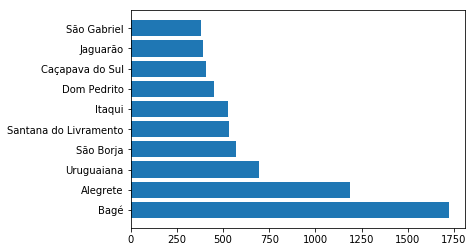

In [17]:
barh(cidades.index, cidades.values)

In [18]:
cidades.Bagé/cidades.sum()*100

25.116482236458943

In [19]:
cidades.Alegrete/cidades.sum()*100

17.26849155503786

## Comparação entre as categorias de evasão